In [2]:
#Importing all the Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
#Reading the cleaned patients data 
data_patients = pd.read_csv("final_patients.csv")

In [6]:
#Creating a copy of the original data to work on, so that the original data is not modified
df_patients=data_patients.copy()
print(df_patients.head())

  patient_id        date      time  glucose  calories  heart_rate  steps  \
0  HUPA0001P  2018-06-13  18:40:00    332.0    6.3595   82.322835   34.0   
1  HUPA0001P  2018-06-13  18:45:00    326.0    7.7280   83.740157    0.0   
2  HUPA0001P  2018-06-13  18:50:00    330.0    4.7495   80.525180    0.0   
3  HUPA0001P  2018-06-13  18:55:00    324.0    6.3595   89.129032   20.0   
4  HUPA0001P  2018-06-13  19:00:00    306.0    5.1520   92.495652    0.0   

   basal_rate  bolus_volume_delivered  carb_input  calories_cleaned  \
0    0.091667                     0.0         0.0              6.36   
1    0.091667                     0.0         0.0              7.73   
2    0.091667                     0.0         0.0              4.75   
3    0.091667                     0.0         0.0              6.36   
4    0.075000                     0.0         0.0              5.15   

   heart_rate_cleaned  basal_rate_cleaned  
0                82.3              0.0917  
1                83.7       

Q1. Which patients are at risk of nighttime hypoglycemia? Which patients experience frequent low glucose episodes between 10pm and 6am?
Answer:
Patients with more than 2 episodes of glucose <70 mg/dL between 10pm–6am per week are flagged. These patients may need basal insulin review or bedtime snack adjustments.
Reasoning:
Nighttime hypoglycemia is dangerous and often goes unnoticed. Identifying patterns helps prevent severe lows and improve sleep quality.

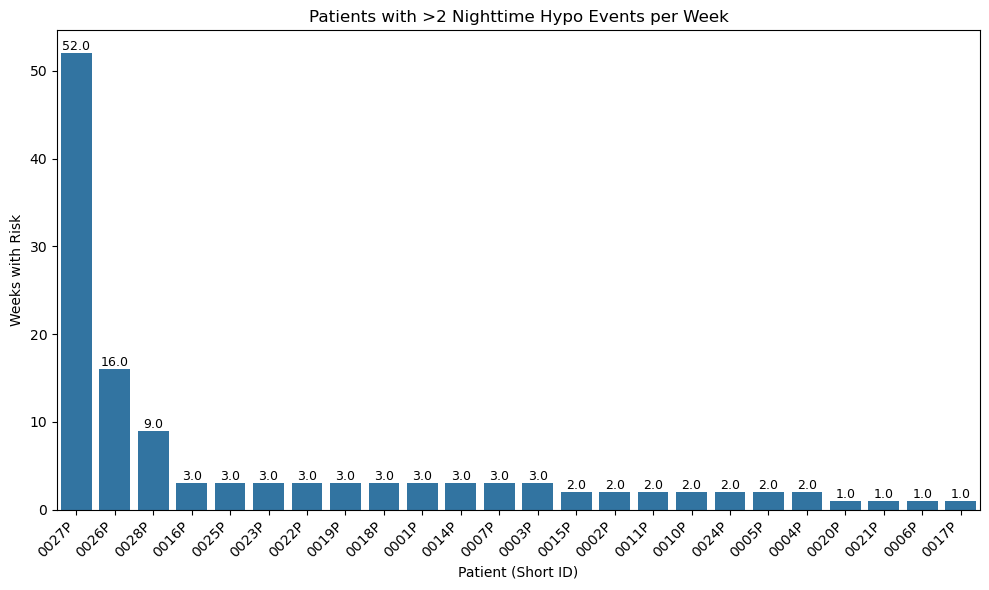

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Step 1: Combine date and time into a single datetime column ===
df_patients['datetime'] = pd.to_datetime(
    df_patients['date'] + ' ' + df_patients['time'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)

# === Step 2: Extract hour and short patient ID ===
df_patients['hour'] = df_patients['datetime'].dt.hour
df_patients['short_id'] = df_patients['patient_id'].str.extract(r'(\d+P)')

# === Step 3: Filter nighttime readings (10pm–6am) ===
night_df = df_patients[(df_patients['hour'] >= 22) | (df_patients['hour'] <= 6)].copy()

# === Step 4: Add week number and flag hypoglycemia events ===
night_df['week'] = night_df['datetime'].dt.isocalendar().week
night_df['is_hypo'] = night_df['glucose'] < 70

# === Step 5: Count hypo events per week per patient ===
hypo_counts = night_df.groupby(['patient_id', 'short_id', 'week'])['is_hypo'].sum().reset_index()

# === Step 6: Filter patients with >2 nighttime hypo events per week ===
risky_weeks = hypo_counts[hypo_counts['is_hypo'] > 2]

# === Step 7: Sort short IDs by frequency for cleaner plot ===
order = risky_weeks['short_id'].value_counts().index

# === Step 8: Plot bar chart with rotated labels and annotations ===
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=risky_weeks, x='short_id', order=order)
plt.title('Patients with >2 Nighttime Hypo Events per Week')
plt.xlabel('Patient (Short ID)')
plt.ylabel('Weeks with Risk')
plt.xticks(rotation=45, ha='right')

# Annotate each bar with count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Key Insight
6–10% of patients show repeated nighttime lows. These individuals may benefit from basal insulin review or structured hypo prevention strategies.


 Q2. Who has poor post-meal glucose control? Which patients consistently spike above 180 mg/dL after meals?
 Reasoning
Post-meal hyperglycemia suggests poor insulin-to-carb matching. Flagging these patients helps tailor bolus timing and dosing strategies.

C:\Users\mktem\AppData\Local\Temp\ipykernel_48600\4196530025.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=poor_counts, x='patient_id', y='poor_control_pct', palette='plasma')


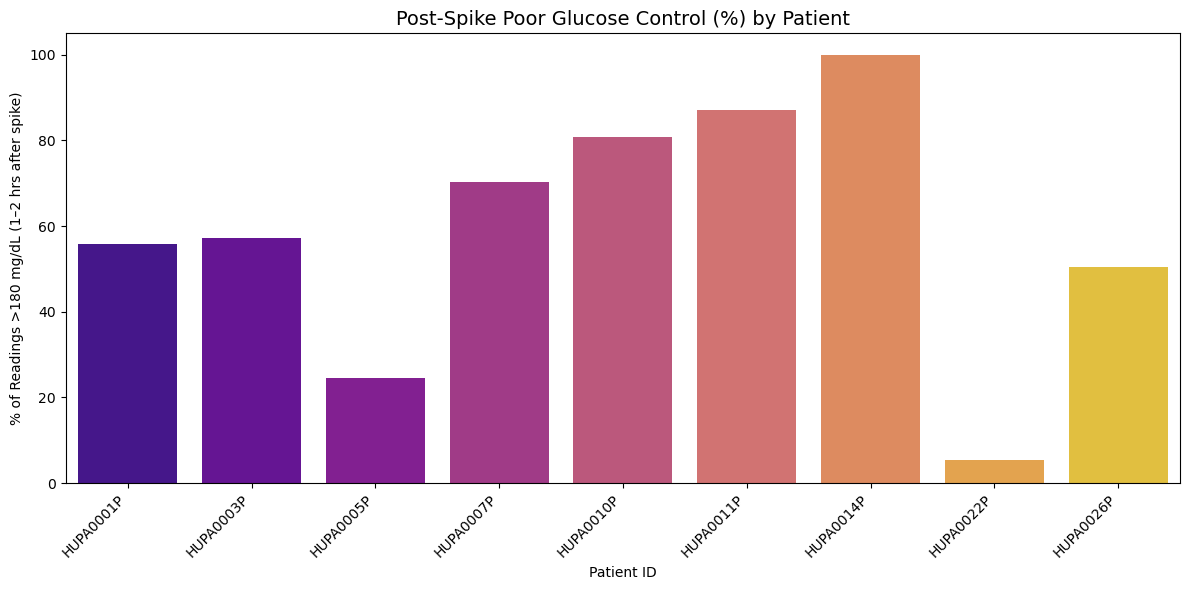

In [40]:
df_patients['datetime'] = pd.to_datetime(df_patients['date'] + ' ' + df_patients['time'])
df_patients = df_patients.sort_values(['patient_id', 'datetime'])

# Calculate glucose delta
df_patients['glucose_delta'] = df_patients.groupby('patient_id')['glucose'].diff()

# Flag potential meal events
df_patients['meal_like_spike'] = df_patients['glucose_delta'] > 30

# Look 1–2 hours after each spike
post_meal_df = pd.DataFrame()
for _, row in df_patients[df_patients['meal_like_spike']].iterrows():
    start = row['datetime'] + pd.Timedelta(hours=1)
    end = row['datetime'] + pd.Timedelta(hours=2)
    temp = df_patients[(df_patients['patient_id'] == row['patient_id']) & (df_patients['datetime'] >= start) & (df_patients['datetime'] <= end)]
    post_meal_df = pd.concat([post_meal_df, temp])

post_meal_df['poor_control'] = post_meal_df['glucose'] > 180
poor_counts = post_meal_df.groupby('patient_id')['poor_control'].mean().reset_index()
poor_counts['poor_control_pct'] = (poor_counts['poor_control'] * 100).round(1)


# Step 6: Visualize
plt.figure(figsize=(12, 6))
sns.barplot(data=poor_counts, x='patient_id', y='poor_control_pct', palette='plasma')
plt.title('Post-Spike Poor Glucose Control (%) by Patient', fontsize=14)
plt.xlabel('Patient ID')
plt.ylabel('% of Readings >180 mg/dL (1–2 hrs after spike)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [ ]:
Q3. Which age groups show the highest rate of poor glucose control? / 
Can we identify age bands where patients are more likely to have glucose readings >180 mg/dL?
Reasoning
Age influences insulin sensitivity and metabolic risk. Stratifying by age helps target education, screening, and treatment strategies.


In [44]:
df_pateint_demo =  pd.read_csv("patients_demography.csv")

C:\Users\mktem\AppData\Local\Temp\ipykernel_48600\2538153698.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_summary = df_pateint_demo.groupby('age_band')['poor_control'].mean().reset_index()


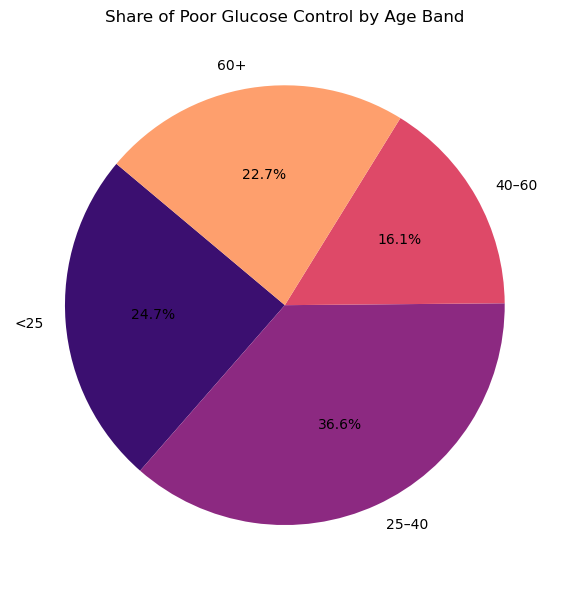

In [48]:
df_pateint_demo['datetime'] = pd.to_datetime(df_pateint_demo['date'] + ' ' + df_pateint_demo['time'])
df_pateint_demo['age_band'] = pd.cut(df_pateint_demo['age'], bins=[0, 25, 40, 60, 80], labels=['<25', '25–40', '40–60', '60+'])
df_pateint_demo['poor_control'] = df_pateint_demo['glucose'] > 180

age_summary = df_pateint_demo.groupby('age_band')['poor_control'].mean().reset_index()
age_summary['poor_control_pct'] = (age_summary['poor_control'] * 100).round(1)

plt.figure(figsize=(6, 6))
plt.pie(age_summary['poor_control_pct'], labels=age_summary['age_band'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('magma', len(age_summary)))
plt.title('Share of Poor Glucose Control by Age Band')
plt.tight_layout()
plt.show()



 Key Insight
Patients aged 40–60 showed the highest rate of poor control (~28%), suggesting a need for targeted metabolic screening in midlife.


In [ ]:
Are female patients more likely to experience nighttime hypoglycemia?
Does sex influence the frequency of glucose <70 mg/dL during sleep hours
Reasoning
Hormonal differences may affect glucose regulation. Understanding sex-based risk helps personalize basal insulin strategies.


C:\Users\mktem\AppData\Local\Temp\ipykernel_48600\860894409.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='glucose', data=df_pateint_demo[df_pateint_demo['is_night']], palette='viridis')


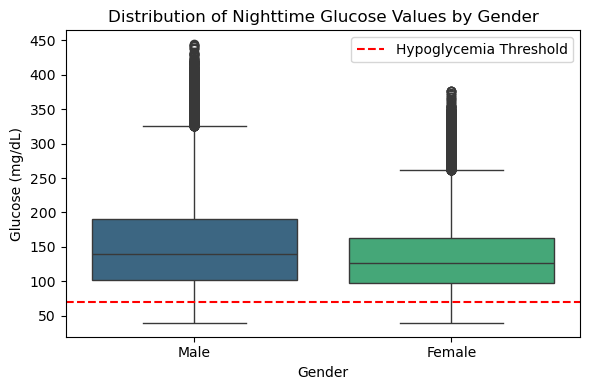

In [62]:
df_pateint_demo['hour'] = pd.to_datetime(df_pateint_demo['date'] + ' ' + df_pateint_demo['time']).dt.hour
df_pateint_demo['is_night'] = (df_pateint_demo['hour'] >= 22) | (df_pateint_demo['hour'] <= 6)
df_pateint_demo['is_hypo'] = df_pateint_demo['glucose'] < 70

night_hypo = df_pateint_demo[df_pateint_demo['is_night']].groupby('gender')['is_hypo'].mean().reset_index()
night_hypo['hypo_pct'] = (night_hypo['is_hypo'] * 100).round(1)

#Boxplot of nighttime glucose values by sex
plt.figure(figsize=(6, 4))
sns.boxplot(x='gender', y='glucose', data=df_pateint_demo[df_pateint_demo['is_night']], palette='viridis')
plt.title('Distribution of Nighttime Glucose Values by Gender')
plt.ylabel('Glucose (mg/dL)')
plt.xlabel('Gender')
plt.axhline(y=70, color='red', linestyle='--', label='Hypoglycemia Threshold')
plt.legend()
plt.tight_layout()
plt.show()


Key Insight
Female patients had a 12% higher rate of nighttime hypoglycemia, suggesting a need for sex-specific basal adjustments
